# Adapting the 2nd Place Solution of the 2021 NCAAW Competition

- Solution write-up is available here : https://www.kaggle.com/c/ncaaw-march-mania-2021/discussion/230705
- 2nd place code : https://www.kaggle.com/theoviel/2nd-place-ncaaw-2021?scriptVersionId=58780991
- It was adapted from this notebook : https://www.kaggle.com/theoviel/ncaa-starter-the-simpler-the-better 

In [1]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None)

In [2]:
DATA_PATH = '/kaggle/input/march-machine-learning-mania-2023/'

for filename in os.listdir(DATA_PATH):
    print(filename)

Conferences.csv
WNCAATourneyDetailedResults.csv
WRegularSeasonCompactResults.csv
MNCAATourneySeedRoundSlots.csv
MRegularSeasonDetailedResults.csv
MNCAATourneyCompactResults.csv
MGameCities.csv
WGameCities.csv
MSeasons.csv
WNCAATourneySlots.csv
MSecondaryTourneyTeams.csv
Cities.csv
SampleSubmission2023.csv
MTeamSpellings.csv
MRegularSeasonCompactResults.csv
MSecondaryTourneyCompactResults.csv
MMasseyOrdinals_thru_Season2023_Day128.csv
WTeams.csv
MNCAATourneySlots.csv
MNCAATourneySeeds.csv
WNCAATourneyCompactResults.csv
WSeasons.csv
WNCAATourneySeeds.csv
MTeamCoaches.csv
MConferenceTourneyGames.csv
WRegularSeasonDetailedResults.csv
MNCAATourneyDetailedResults.csv
WTeamSpellings.csv
MTeamConferences.csv
MTeams.csv
WTeamConferences.csv


# Data preparation

## Seeds
> This file identifies the seeds for all teams in each NCAA® tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on whether there were any play-in games and how many there were. In recent years the structure has settled at 68 total teams, with four "play-in" games leading to the final field of 64 teams entering Round 1 on Thursday of the first week (by definition, that is DayNum=136 each season). We will not know the seeds of the respective tournament teams, or even exactly which 68 teams it will be, until Selection Sunday on March 15, 2020 (DayNum=132).

> The seed is a 3/4-character :
- First character : Region (W, X, Y, or Z)
- Next two digits : Seed within the region (01 to 16)
- Last character (optional): Distinguishes teams between play-ins ( a or b)

In [3]:
df_seeds = pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv")
df_seeds.head()

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272


# Season results
> This file identifies the game-by-game results for many seasons of historical data, starting with the 1985 season (the first year the NCAA® had a 64-team tournament). For each season, the file includes all games played from DayNum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, or whatever.

In [4]:
df_season_results = pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv")
df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,23,54,5,9,12,19,10,26,14,18,7,0,15,20,54,3,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,26,62,5,12,16,28,16,31,15,20,5,2,25,25,63,4,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,29,62,6,15,7,12,14,23,18,13,6,2,17,19,58,2,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,27,52,4,11,5,9,6,40,14,27,5,10,18,18,74,6,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,30,74,7,20,7,11,14,33,18,11,5,3,18,25,74,9,17,11,21,21,32,12,14,4,2,14


In [5]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']
df_season_results['AstGap'] = df_season_results['WAst'] - df_season_results['LAst']
df_season_results['FTAGap'] = df_season_results['WFTA'] - df_season_results['LFTA']
df_season_results['DRGap'] = df_season_results['WDR'] - df_season_results['LDR']
df_season_results['TOGap'] = df_season_results['WTO'] - df_season_results['LTO']

In [6]:
# df_30 = df_season_results[df_season_results.DayNum >= 101]

# Features 
For each team at each season, I compute : 
- Number of wins
- Number of losses
- Average score gap of wins
- Average score gap of losses

And use the following features : 
- Win Ratio
- Average score gap

In [7]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})
num_win

,Season,TeamID,NumWins
0,2010,3102,1
1,2010,3103,17
2,2010,3104,11
3,2010,3105,14
4,2010,3106,12
...,...,...,...
4855,2023,3473,1
4856,2023,3474,5
4857,2023,3475,9
4858,2023,3476,8


In [8]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})
num_loss

,Season,TeamID,NumLosses
0,2010,3102,27
1,2010,3103,13
2,2010,3104,18
3,2010,3105,13
4,2010,3106,17
...,...,...,...
4865,2023,3473,24
4866,2023,3474,21
4867,2023,3475,17
4868,2023,3476,20


In [9]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})
gap_win

,Season,TeamID,GapWins
0,2010,3102,20.000000
1,2010,3103,13.176471
2,2010,3104,15.363636
3,2010,3105,7.357143
4,2010,3106,8.500000
...,...,...,...
4855,2023,3473,9.000000
4856,2023,3474,10.200000
4857,2023,3475,13.000000
4858,2023,3476,10.125000


In [10]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreGap,AstGap,FTAGap,DRGap,TOGap
0,2010,11,3103,63,3237,49,23,54,5,9,12,19,10,26,14,18,7,0,15,20,54,3,13,6,10,11,27,11,23,7,6,19,14,3,9,-1,-5
1,2010,11,3104,73,3399,68,26,62,5,12,16,28,16,31,15,20,5,2,25,25,63,4,21,14,27,14,26,7,20,4,2,27,5,8,1,5,0
2,2010,11,3110,71,3224,59,29,62,6,15,7,12,14,23,18,13,6,2,17,19,58,2,14,19,23,17,23,8,15,6,0,15,12,10,-11,0,-2
3,2010,11,3111,63,3267,58,27,52,4,11,5,9,6,40,14,27,5,10,18,18,74,6,26,16,25,22,22,15,11,14,5,14,5,-1,-16,18,16
4,2010,11,3119,74,3447,70,30,74,7,20,7,11,14,33,18,11,5,3,18,25,74,9,17,11,21,21,32,12,14,4,2,14,4,6,-10,1,-3


In [11]:
win = df_season_results.groupby(['Season', 'WTeamID']).sum().reset_index()
ast_win = win[['Season', 'WTeamID', 'WAst']].rename(columns={"WTeamID": "TeamID"})
fta_win = win[['Season', 'WTeamID', 'WFTA']].rename(columns={"WTeamID": "TeamID"})
dr_win = win[['Season', 'WTeamID', 'WDR']].rename(columns={"WTeamID": "TeamID"})
fga_win = win[['Season', 'WTeamID', 'WFGA']].rename(columns={"WTeamID": "TeamID"})
to_win = win[['Season', 'WTeamID', 'WTO']].rename(columns={"WTeamID": "TeamID"})
to_win

,Season,TeamID,WTO
0,2010,3102,14
1,2010,3103,287
2,2010,3104,226
3,2010,3105,360
4,2010,3106,231
...,...,...,...
4855,2023,3473,25
4856,2023,3474,65
4857,2023,3475,158
4858,2023,3476,109


**avg_ast = (wast + last)/(numw + numl)**

In [12]:
loss = df_season_results.groupby(['Season', 'LTeamID']).sum().reset_index()
ast_loss = loss[['Season', 'LTeamID', 'LAst']].rename(columns={"LTeamID": "TeamID"})
fta_loss = loss[['Season', 'LTeamID', 'LFTA']].rename(columns={"LTeamID": "TeamID"})
dr_loss = loss[['Season', 'LTeamID', 'LDR']].rename(columns={"LTeamID": "TeamID"})
fga_loss = loss[['Season', 'LTeamID', 'LFGA']].rename(columns={"LTeamID": "TeamID"})
to_loss = loss[['Season', 'LTeamID', 'LTO']].rename(columns={"LTeamID": "TeamID"})

In [13]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})
gap_loss

,Season,TeamID,GapLosses
0,2010,3102,21.444444
1,2010,3103,11.230769
2,2010,3104,14.000000
3,2010,3105,16.153846
4,2010,3106,9.882353
...,...,...,...
4865,2023,3473,18.500000
4866,2023,3474,20.523810
4867,2023,3475,12.176471
4868,2023,3476,12.800000


## Merge

In [14]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})
df_features_season_l

,Season,TeamID
0,2010,3102
1,2010,3103
2,2010,3104
3,2010,3105
4,2010,3106
...,...,...
4865,2023,3473
4866,2023,3474
4867,2023,3475
4868,2023,3476


In [15]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)
df_features_season

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.


,Season,TeamID
0,2010,3102
1,2010,3103
2,2010,3104
3,2010,3105
4,2010,3106
...,...,...
4875,2023,3473
4876,2023,3474
4877,2023,3475
4878,2023,3476


In [16]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

In [17]:
df_features_season = df_features_season.merge(ast_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fta_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(dr_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(to_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fga_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(ast_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fta_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(dr_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(to_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fga_win, on=['Season', 'TeamID'], how='left')

In [18]:
df_features_season.fillna(0, inplace=True)  

In [19]:
df_features_season

,Season,TeamID,NumWins,NumLosses,GapWins,GapLosses,LAst,LFTA,LDR,LTO,LFGA,WAst,WFTA,WDR,WTO,WFGA
0,2010,3102,1.0,27.0,20.000000,21.444444,274.0,349.0,518.0,482.0,1437.0,13.0,21.0,29.0,14.0,51.0
1,2010,3103,17.0,13.0,13.176471,11.230769,161.0,251.0,269.0,261.0,706.0,242.0,337.0,438.0,287.0,952.0
2,2010,3104,11.0,18.0,15.363636,14.000000,191.0,271.0,444.0,330.0,1146.0,189.0,216.0,308.0,226.0,655.0
3,2010,3105,14.0,13.0,7.357143,16.153846,105.0,286.0,273.0,316.0,707.0,158.0,371.0,358.0,360.0,666.0
4,2010,3106,12.0,17.0,8.500000,9.882353,187.0,358.0,411.0,352.0,939.0,146.0,338.0,307.0,231.0,598.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4875,2023,3473,1.0,24.0,9.000000,18.500000,271.0,313.0,456.0,457.0,1211.0,26.0,16.0,25.0,25.0,47.0
4876,2023,3474,5.0,21.0,10.200000,20.523810,122.0,386.0,422.0,329.0,1215.0,48.0,96.0,112.0,65.0,295.0
4877,2023,3475,9.0,17.0,13.000000,12.176471,208.0,301.0,379.0,360.0,905.0,130.0,185.0,239.0,158.0,531.0
4878,2023,3476,8.0,20.0,10.125000,12.800000,265.0,256.0,432.0,298.0,1113.0,127.0,125.0,200.0,109.0,450.0


In [20]:
df_features_season['NumTotal'] = df_features_season['NumWins'] + df_features_season['NumLosses']
df_features_season['AstAvg'] = (df_features_season['LAst'] + df_features_season['WAst'])/ df_features_season['NumTotal']
df_features_season['FTAAvg'] = (df_features_season['LFTA'] + df_features_season['WFTA']) / df_features_season['NumTotal']
df_features_season['DRAvg'] = (df_features_season['LDR'] + df_features_season['WDR']) / df_features_season['NumTotal']
df_features_season['TOAvg'] = (df_features_season['LTO'] + df_features_season['WTO']) /df_features_season['NumTotal']
df_features_season['FGAAvg'] = (df_features_season['LFGA'] + df_features_season['WFGA']) /df_features_season['NumTotal']

df_features_season.head()

,Season,TeamID,NumWins,NumLosses,GapWins,GapLosses,LAst,LFTA,LDR,LTO,LFGA,WAst,WFTA,WDR,WTO,WFGA,NumTotal,AstAvg,FTAAvg,DRAvg,TOAvg,FGAAvg
0,2010,3102,1.0,27.0,20.000000,21.444444,274.0,349.0,518.0,482.0,1437.0,13.0,21.0,29.0,14.0,51.0,28.0,10.250000,13.214286,19.535714,17.714286,53.142857
1,2010,3103,17.0,13.0,13.176471,11.230769,161.0,251.0,269.0,261.0,706.0,242.0,337.0,438.0,287.0,952.0,30.0,13.433333,19.600000,23.566667,18.266667,55.266667
2,2010,3104,11.0,18.0,15.363636,14.000000,191.0,271.0,444.0,330.0,1146.0,189.0,216.0,308.0,226.0,655.0,29.0,13.103448,16.793103,25.931034,19.172414,62.103448
3,2010,3105,14.0,13.0,7.357143,16.153846,105.0,286.0,273.0,316.0,707.0,158.0,371.0,358.0,360.0,666.0,27.0,9.740741,24.333333,23.370370,25.037037,50.851852
4,2010,3106,12.0,17.0,8.500000,9.882353,187.0,358.0,411.0,352.0,939.0,146.0,338.0,307.0,231.0,598.0,29.0,11.482759,24.000000,24.758621,20.103448,53.000000


Compute features

In [21]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [22]:
df_features_season['TORate'] = (df_features_season['TOAvg']*100)/(df_features_season['FGAAvg'] + (df_features_season['FTAAvg'] * 0.44) + df_features_season['AstAvg'] + df_features_season['TOAvg'])

In [23]:
# df_features_season['PSM'] = 0.062* (df_features_season['FTAAvg'] - ) + 1.49* df_features_season['DRAvg'] + 0.587 * df_features_season['AstAvg'] - 1.601 * df_features_season['TOAvg']

In [24]:
# , 'LAst', 'LFTA', 'LDR', 'LTO', 'WAst', 'WFTA','WDR','WTO', 'NumTotal'
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses','LAst','LFGA', 'WFGA','LFTA', 'LDR', 'LTO', 'WAst', 'WFTA','WDR','WTO', 'NumTotal', 'FGAAvg', 'TOAvg', 'FTAAvg' ], axis=1, inplace=True)

In [25]:
df_features_season.head()

,Season,TeamID,AstAvg,DRAvg,WinRatio,GapAvg,TORate
0,2010,3102,10.250000,19.535714,0.035714,-19.964286,20.379653
1,2010,3103,13.433333,23.566667,0.566667,2.600000,19.109258
2,2010,3104,13.103448,25.931034,0.379310,-2.862069,18.839283
3,2010,3105,9.740741,23.370370,0.518519,-3.962963,25.989204
4,2010,3106,11.482759,24.758621,0.413793,-2.275862,21.129007


## Tourney results

> This file identifies the game-by-game NCAA® tournament results for all seasons of historical data. The data is formatted exactly like the MRegularSeasonCompactResults data. All games will show up as neutral site (so WLoc is always N). Note that this tournament game data also includes the play-in games (which always occurred on day 134/135) for those years that had play-in games. Thus each season you will see between 63 and 67 games listed, depending on how many play-in games there were.

In [26]:
df_tourney_results = pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv")
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [27]:
df_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1998,137,3104,94,3422,46
1,1998,137,3112,75,3365,63
2,1998,137,3163,93,3193,52
3,1998,137,3198,59,3266,45
4,1998,137,3203,74,3208,72
...,...,...,...,...,...,...
1511,2022,147,3163,91,3301,87
1512,2022,147,3257,62,3276,50
1513,2022,151,3163,63,3390,58
1514,2022,151,3376,72,3257,59


## FiveThirtyEight Ratings / Kenpom
> Thanks to Raddar ! https://www.kaggle.com/raddar/ncaa-women-538-team-ratings



In [28]:
df_538 = pd.read_csv("/kaggle/input/ncaa-women-538-team-ratings/538ratingsWomen.csv")
df_538.drop('TeamName', axis=1, inplace=True)

df_538

,Season,TeamID,538rating
0,2016,3163,113.09
1,2016,3124,101.59
2,2016,3323,101.07
3,2016,3376,101.07
4,2016,3268,99.01
...,...,...,...
451,2023,3368,66.27
452,2023,3151,64.88
453,2023,3284,62.69
454,2023,3380,61.75


# Feature Engineering

## Train data

In [29]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 2016].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2016,137,3107,61,3196,59
1,2016,137,3113,74,3308,52
2,2016,137,3120,68,3385,57
3,2016,137,3124,89,3225,59
4,2016,137,3177,97,3241,67


### Seeds
- `SeedW` is the seed of the winning team
- `SeedL` is the seed of the losing team

In [30]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [31]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [32]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [33]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

### Season Stats
- `WinRatioW` is the win ratio of the winning team during the season
- `WinRatioL` is the win ratio of the losing team during the season

In [34]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
    'AstAvg': 'AstAvgW',
    'DRAvg': 'DRAvgW',
    'TORate': 'TORateW'
}).drop(columns='TeamID', axis=1)

In [35]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
    'AstAvg': 'AstAvgL',
    'DRAvg': 'DRAvgL',
    'TORate': 'TORateL'
}).drop(columns='TeamID', axis=1)

### FiveThirtyEight Ratings
- `538ratingW` is the rating of the winning team during the season
- `538ratingL` is the rating of the losing team during the season

In [36]:
df = pd.merge(
    df,
    df_538,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingW'})

In [37]:
df = pd.merge(
    df, 
    df_538, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingL'})

In [38]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,AstAvgW,DRAvgW,WinRatioW,GapAvgW,TORateW,AstAvgL,DRAvgL,WinRatioL,GapAvgL,TORateL,538ratingW,538ratingL
0,2016,137,3107,61,3196,59,12,5,16.193548,24.645161,0.870968,18.677419,15.052532,15.066667,25.566667,0.733333,8.700000,18.985392,80.90,83.36
1,2016,137,3113,74,3308,52,2,15,14.709677,22.967742,0.806452,9.258065,15.740817,13.071429,24.607143,0.857143,8.964286,15.618011,91.32,71.42
2,2016,137,3120,68,3385,57,9,8,13.161290,21.838710,0.612903,3.032258,18.769321,13.062500,25.437500,0.718750,6.812500,15.427732,80.17,82.19
3,2016,137,3124,89,3225,59,1,16,20.794118,31.176471,0.970588,24.617647,14.340239,15.580645,29.419355,0.709677,10.612903,13.698889,101.59,72.69
4,2016,137,3177,97,3241,67,6,11,20.909091,25.303030,0.757576,16.272727,12.200842,12.531250,29.062500,0.843750,15.406250,13.530863,90.08,83.04


### Add symetrical
- Right now our data only consists of won matches
- We duplicate our data, get rid of the winner loser 

In [39]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

In [40]:
df = add_loosing_matches(df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


### Differences
- We compute the difference between the team for each feature.
- This helps further assessing how better (or worse) team A is from team B

In [41]:
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,AstAvgA,DRAvgA,WinRatioA,GapAvgA,TORateA,AstAvgB,DRAvgB,WinRatioB,GapAvgB,TORateB,538ratingA,538ratingB
0,2016,137,3107,61,3196,59,12,5,16.193548,24.645161,0.870968,18.677419,15.052532,15.066667,25.566667,0.733333,8.700000,18.985392,80.90,83.36
1,2016,137,3113,74,3308,52,2,15,14.709677,22.967742,0.806452,9.258065,15.740817,13.071429,24.607143,0.857143,8.964286,15.618011,91.32,71.42
2,2016,137,3120,68,3385,57,9,8,13.161290,21.838710,0.612903,3.032258,18.769321,13.062500,25.437500,0.718750,6.812500,15.427732,80.17,82.19
3,2016,137,3124,89,3225,59,1,16,20.794118,31.176471,0.970588,24.617647,14.340239,15.580645,29.419355,0.709677,10.612903,13.698889,101.59,72.69
4,2016,137,3177,97,3241,67,6,11,20.909091,25.303030,0.757576,16.272727,12.200842,12.531250,29.062500,0.843750,15.406250,13.530863,90.08,83.04


## RPI
### .25*(Team’s Winning Percentage)+.50*(Opponents’  Average Winning Percentage)+0.25*(Opponents’ Opponents’  Average Winning Percentage)

In [42]:
all_stats = pd.read_csv('/kaggle/input/march-machine-learning-mania-2023/WRegularSeasonCompactResults.csv')
all_stats = all_stats[all_stats['Season'] >= 2016]

In [43]:
def Average(lst):
    return sum(lst) / len(lst)

In [44]:
season_stats = all_stats[all_stats.Season == 2016]

In [45]:
df_season = df_features_season[df_features_season.Season == 2016]
df_season.head()

,Season,TeamID,AstAvg,DRAvg,WinRatio,GapAvg,TORate
2071,2016,3101,14.000000,25.120000,0.880000,10.000000,16.977861
2072,2016,3102,10.133333,21.533333,0.033333,-20.966667,21.605482
2073,2016,3103,14.161290,27.838710,0.580645,0.225806,14.869458
2074,2016,3104,10.633333,25.533333,0.500000,5.733333,17.577706
2075,2016,3105,11.172414,22.931034,0.137931,-19.241379,20.952769


In [46]:
#  Calculate OA and OB
df_all = pd.DataFrame()
for season in [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]:
    df_season = df_features_season[df_features_season.Season == season].copy()
    df_season['OA'] = 0
    season_stats = all_stats[all_stats.Season == season]
    for team in df_season.TeamID.unique():
        ratios = []
        if season_stats.loc[season_stats.WTeamID == team].LTeamID.any():
            wins = season_stats.loc[season_stats.WTeamID == team]
            for team_l in wins.LTeamID.unique():
                if team_l in df_season.TeamID.values:
                    ratio = df_season.loc[df_season.TeamID == team_l].WinRatio.mean()
                    ratios.append(ratio)
        if season_stats.loc[season_stats.LTeamID == team].WTeamID.any():
            loss = season_stats.loc[season_stats.LTeamID == team]
            for team_w in loss.WTeamID.unique():
                if team_w in df_season.TeamID.values:
                    ratio = df_season.loc[df_season.TeamID == team_w].WinRatio.mean()
                    ratios.append(ratio)
        if len(ratios) > 0:
            df_season.loc[df_season.TeamID == team, 'OA'] = Average(ratios)
    df_season = df_season[['Season', 'TeamID', 'OA']].rename(columns={'TeamID': 'TeamIdA'})
    df_all = pd.concat([df_all, df_season])
df = df.merge(df_all, how = 'left', on = ['Season','TeamIdA'])
df_all = df_all.rename(columns = {'TeamIdA':'TeamIdB', 'OA':'OB'})
df = df.merge(df_all, how = 'left', on = ['Season','TeamIdB'])
df = df.drop_duplicates().reset_index().drop('index', axis=1)

In [47]:
# Calculate OOA and OOB
df_all = pd.DataFrame()
for season in [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]:
    df_season = df_features_season[df_features_season.Season == season].copy()
    df_season['OOA'] = 0
    season_stats = all_stats[all_stats.Season == season]
    for team in df_season.TeamID.unique():
        ratios = []
        if season_stats.loc[season_stats.WTeamID == team].LTeamID.any() or season_stats.loc[season_stats.LTeamID == team].WTeamID.any():
            wins = season_stats.loc[season_stats.WTeamID == team]
            for team_l in wins.LTeamID.unique():
                wins_o = season_stats.loc[season_stats.LTeamID == team_l]
                for team_l_o in wins_o.WTeamID.unique():
                    if team_l_o in df_season.TeamID.values:
                        ratio = df_season.loc[df_season.TeamID == team_l_o].WinRatio.mean()
                        ratios.append(ratio)
            loss = season_stats.loc[season_stats.LTeamID == team]
            for team_l in loss.WTeamID.unique():
                loss_o = season_stats.loc[season_stats.WTeamID == team_l]
                for team_l_o in loss_o.LTeamID.unique():
                    if team_l_o in df_season.TeamID.values:
                        ratio = df_season.loc[df_season.TeamID == team_l_o].WinRatio.mean()
                        ratios.append(ratio)
            if len(ratios) > 0:
                df_season.loc[df_season.TeamID == team, 'OOA'] = Average(ratios)
    df_season = df_season[['Season', 'TeamID', 'OOA']].rename(columns={'TeamID': 'TeamIdA'})
    df_all = pd.concat([df_all, df_season])
    df_all = df_all.drop_duplicates().reset_index().drop('index', axis=1)
df = df.merge(df_all, how = 'left', on = ['Season','TeamIdA'])
df_all = df_all.rename(columns = {'TeamIdA':'TeamIdB', 'OOA':'OOB'})
df = df.merge(df_all, how = 'left', on = ['Season','TeamIdB'])
df = df.drop_duplicates().reset_index().drop('index', axis=1)

In [48]:
df['PRIA'] = (df['WinRatioA'] * 0.25) + (df['OA'] * 0.5) + (df['OOA'] * 0.25)
df['PRIB'] = (df['WinRatioB'] * 0.25) + (df['OB'] * 0.5) + (df['OOB'] * 0.25)

In [49]:
#  'AstAvg', 'FTAAvg', 'DRAvg', 'TOAvg'
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg', '538rating', 'AstAvg', 'DRAvg', 'TORate', 'PRI'
]

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

In [50]:
df

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,AstAvgA,DRAvgA,WinRatioA,GapAvgA,TORateA,AstAvgB,DRAvgB,WinRatioB,GapAvgB,TORateB,538ratingA,538ratingB,OA,OB,OOA,OOB,PRIA,PRIB,SeedDiff,WinRatioDiff,GapAvgDiff,538ratingDiff,AstAvgDiff,DRAvgDiff,TORateDiff,PRIDiff
0,2016,137,3107,61,3196,59,12,5,16.193548,24.645161,0.870968,18.677419,15.052532,15.066667,25.566667,0.733333,8.700000,18.985392,80.90,83.36,0.465564,0.563728,0.546547,0.583374,0.587161,0.611041,7,0.137634,9.977419,-2.46,1.126882,-0.921505,-3.932860,-0.023880
1,2016,137,3113,74,3308,52,2,15,14.709677,22.967742,0.806452,9.258065,15.740817,13.071429,24.607143,0.857143,8.964286,15.618011,91.32,71.42,0.583962,0.408425,0.611864,0.540788,0.646560,0.553695,-13,-0.050691,0.293779,19.90,1.638249,-1.639401,0.122806,0.092865
2,2016,137,3120,68,3385,57,9,8,13.161290,21.838710,0.612903,3.032258,18.769321,13.062500,25.437500,0.718750,6.812500,15.427732,80.17,82.19,0.549446,0.510343,0.561986,0.572805,0.568445,0.578060,1,-0.105847,-3.780242,-2.02,0.098790,-3.598790,3.341589,-0.009615
3,2016,137,3124,89,3225,59,1,16,20.794118,31.176471,0.970588,24.617647,14.340239,15.580645,29.419355,0.709677,10.612903,13.698889,101.59,72.69,0.578084,0.472108,0.652387,0.523931,0.694786,0.544456,-15,0.260911,14.004744,28.90,5.213472,1.757116,0.641350,0.150330
4,2016,137,3177,97,3241,67,6,11,20.909091,25.303030,0.757576,16.272727,12.200842,12.531250,29.062500,0.843750,15.406250,13.530863,90.08,83.04,0.595631,0.507240,0.564214,0.559464,0.628263,0.604423,-5,-0.086174,0.866477,7.04,8.377841,-3.759470,-1.330021,0.023839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,2022,147,3301,87,3163,91,1,2,14.250000,27.687500,0.906250,19.343750,12.665039,18.833333,25.133333,0.833333,20.600000,13.825480,101.78,98.35,0.612216,0.593645,0.663449,0.610154,0.698533,0.657694,-1,0.072917,-1.256250,3.43,-4.583333,2.554167,-1.160440,0.040839
760,2022,147,3276,50,3257,62,3,1,13.964286,24.928571,0.785714,11.178571,15.899835,15.862069,23.793103,0.862069,17.137931,14.505336,90.12,97.40,0.580898,0.563668,0.599719,0.613811,0.636807,0.650804,2,-0.076355,-5.959360,-7.28,-1.897783,1.135468,1.394498,-0.013997
761,2022,151,3390,58,3163,63,1,2,15.129032,26.419355,0.903226,16.903226,12.880217,18.833333,25.133333,0.833333,20.600000,13.825480,101.83,98.35,0.617215,0.593645,0.639237,0.610154,0.694223,0.657694,-1,0.069892,-3.696774,3.48,-3.704301,1.286022,-0.945262,0.036528
762,2022,151,3257,59,3376,72,1,1,15.862069,23.793103,0.862069,17.137931,14.505336,14.193548,28.677419,0.935484,19.612903,14.187751,97.40,106.36,0.563668,0.640792,0.613811,0.677779,0.650804,0.723711,0,-0.073415,-2.474972,-8.96,1.668521,-4.884316,0.317585,-0.072907


### Preparing

Prepare for Female test data

In [51]:
df_test = pd.read_csv("/kaggle/input/march-machine-learning-mania-2023/SampleSubmission2023.csv")

In [52]:
df_test[['Season', 'TeamIdA', 'TeamIdB']] = pd.DataFrame(df_test['ID'].str.split('_').values.tolist(), index = df_test.index)
df_test = df_test[df_test.TeamIdA > '3000']
df_test['Season'] = pd.to_numeric(df_test.Season)
df_test['TeamIdA'] = pd.to_numeric(df_test.TeamIdA)
df_test['TeamIdB'] = pd.to_numeric(df_test.TeamIdB)

In [53]:
# df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
# df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
# df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))
# df_test = df_test[df_test.TeamIdA.astype(int) < '3000']

### Seeds

In [54]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})

In [55]:
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})

In [56]:
df_test = df_test.fillna(value="A1")

In [57]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

In [58]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB
0,2023_3101_3102,0.5,2023,3101,3102,1,1
1,2023_3101_3103,0.5,2023,3101,3103,1,1
2,2023_3101_3104,0.5,2023,3101,3104,1,10
3,2023_3101_3105,0.5,2023,3101,3105,1,1
4,2023_3101_3106,0.5,2023,3101,3106,1,1


### Season Stats

In [59]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
    'AstAvg': 'AstAvgA',
    'DRAvg': 'DRAvgA',
    'TORate': 'TORateA'
}).drop(columns='TeamID', axis=1)

In [60]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
    'AstAvg': 'AstAvgB',
    'DRAvg': 'DRAvgB',
    'TORate': 'TORateB'
}).drop(columns='TeamID', axis=1)

In [61]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,AstAvgA,DRAvgA,WinRatioA,GapAvgA,TORateA,AstAvgB,DRAvgB,WinRatioB,GapAvgB,TORateB
0,2023_3101_3102,0.5,2023,3101,3102,1,1,13.925926,22.0,0.444444,2.333333,15.863447,11.724138,19.000000,0.379310,-2.241379,13.792785
1,2023_3101_3103,0.5,2023,3101,3103,1,1,13.925926,22.0,0.444444,2.333333,15.863447,15.107143,25.392857,0.535714,-0.785714,16.406953
2,2023_3101_3104,0.5,2023,3101,3104,1,10,13.925926,22.0,0.444444,2.333333,15.863447,13.200000,22.600000,0.666667,10.100000,16.201215
3,2023_3101_3105,0.5,2023,3101,3105,1,1,13.925926,22.0,0.444444,2.333333,15.863447,9.517241,23.793103,0.482759,-4.517241,17.954909
4,2023_3101_3106,0.5,2023,3101,3106,1,1,13.925926,22.0,0.444444,2.333333,15.863447,11.333333,20.466667,0.500000,-7.500000,18.842404


### Ratings

In [62]:
df_test = pd.merge(
    df_test,
    df_538,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingA'})

In [63]:
df_test = pd.merge(
    df_test,
    df_538,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingB'})

In [64]:
df_season = df_features_season[df_features_season.Season == 2023].copy()
df_season['OA'] = 0
season_stats = all_stats[all_stats.Season == 2023]
for team in df_season.TeamID.unique():
    ratios = []
    if season_stats.loc[season_stats.WTeamID == team].LTeamID.any():
        wins = season_stats.loc[season_stats.WTeamID == team]
        for team_l in wins.LTeamID.unique():
            if team_l in df_season.TeamID.values:
                ratio = df_season.loc[df_season.TeamID == team_l].WinRatio.mean()
                ratios.append(ratio)
    if season_stats.loc[season_stats.LTeamID == team].WTeamID.any():
        loss = season_stats.loc[season_stats.LTeamID == team]
        for team_w in loss.WTeamID.unique():
            if team_w in df_season.TeamID.values:
                ratio = df_season.loc[df_season.TeamID == team_w].WinRatio.mean()
                ratios.append(ratio)
    if len(ratios) > 0:
        df_season.loc[df_season.TeamID == team, 'OA'] = Average(ratios)
df_season = df_season[['Season', 'TeamID', 'OA']].rename(columns={'TeamID': 'TeamIdA'})
df_test = df_test.merge(df_season, how = 'left', on = ['Season','TeamIdA'])
df_season = df_season.rename(columns = {'TeamIdA':'TeamIdB', 'OA':'OB'})
df_test = df_test.merge(df_season, how = 'left', on = ['Season','TeamIdB'])
df_test = df_test.drop_duplicates().reset_index().drop('index', axis=1)

In [65]:
df_season = df_features_season[df_features_season.Season == 2023].copy()
df_season['OOA'] = 0
season_stats = all_stats[all_stats.Season == 2023]
for team in df_season.TeamID.unique():
    ratios = []
    if season_stats.loc[season_stats.WTeamID == team].LTeamID.any() or season_stats.loc[season_stats.LTeamID == team].WTeamID.any():
        wins = season_stats.loc[season_stats.WTeamID == team]
        for team_l in wins.LTeamID.unique():
            wins_o = season_stats.loc[season_stats.LTeamID == team_l]
            for team_l_o in wins_o.WTeamID.unique():
                if team_l_o in df_season.TeamID.values:
                    ratio = df_season.loc[df_season.TeamID == team_l_o].WinRatio.mean()
                    ratios.append(ratio)
        loss = season_stats.loc[season_stats.LTeamID == team]
        for team_l in loss.WTeamID.unique():
            loss_o = season_stats.loc[season_stats.WTeamID == team_l]
            for team_l_o in loss_o.LTeamID.unique():
                if team_l_o in df_season.TeamID.values:
                    ratio = df_season.loc[df_season.TeamID == team_l_o].WinRatio.mean()
                    ratios.append(ratio)
        if len(ratios) > 0:
            df_season.loc[df_season.TeamID == team, 'OOA'] = Average(ratios)
df_season = df_season[['Season', 'TeamID', 'OOA']].rename(columns={'TeamID': 'TeamIdA'})
df_test = df_test.merge(df_season, how = 'left', on = ['Season','TeamIdA'])
df_test = df_test.drop_duplicates().reset_index().drop('index', axis=1)
df_season = df_season.rename(columns = {'TeamIdA':'TeamIdB', 'OOA':'OOB'})
df_test = df_test.merge(df_season, how = 'left', on = ['Season','TeamIdB'])
df_test = df_test.drop_duplicates().reset_index().drop('index', axis=1)

In [66]:
df_test['PRIA'] = (df_test['WinRatioA'] * 0.25) + (df_test['OA'] * 0.5) + (df_test['OOA'] * 0.25)
df_test['PRIB'] = (df_test['WinRatioB'] * 0.25) + (df_test['OB'] * 0.5) + (df_test['OOB'] * 0.25)

### Differences

In [67]:
for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

In [68]:
# kenpom = pd.read_csv('/kaggle/input/kenneth-pomeroy-data-scraper-no-leakage-update')

## Target

In [69]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

# Modeling

In [70]:
features = [
    'SeedDiff',
    '538ratingDiff',
    'WinRatioDiff', 
    'GapAvgDiff', 
    'PRIDiff',
    'TORateDiff',
    'DRAvgDiff',
#     'AstAvgDiff',
#     'FTAAvgDiff',
#     'TOAvgDiff',
#     'PSMDiff'
]

In [71]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

In [72]:
# df_val = df[df['Season'] == 2020].reset_index(drop=True).copy()
# df_train = df[df['Season'] < 2020].reset_index(drop=True).copy()
# rescale(features, df_train, df_val, df_test)

# Cross Validation
- Validate on season `n`, for `n` in the 3 last seasons. 
- Train on earlier seasons. First available season is 2016 because of the FiveThirtyEight ratings.
- Pipeline support classification (predict the team that wins) and regression (predict the score gap), but classification worked better on CV.

In [73]:
import sklearn
from sklearn.calibration import calibration_curve
import matplotlib.lines as line
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegressionCV


from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [74]:
# from xgboost import cv
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import mean_squared_error


# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 180,
#         'seed': 0
#     }

In [75]:
# def objective(space):
#     target = "WinA"
#     model = XGBClassifier(n_estimators =space['n_estimators'], 
#                                       max_depth = int(space['max_depth']), 
#                                       min_child_weight=int(space['min_child_weight']),
#                                       colsample_bytree=int(space['colsample_bytree']))
                
#     evaluation = [(df_val[features], df_val[target])]
                
#     model.fit(df_train[features], df_train[target], eval_set=evaluation, early_stopping_rounds=100, verbose=False)
    
#     pred = model.predict(df_val[features])
# #     loss = brier_score_loss(df_val[target], pred>0.5)
#     accuracy = accuracy_score(df_val[target], pred>0.5)
    
#     print ("SCORE:", accuracy)
#     return {'loss': -accuracy, 'status': STATUS_OK }

In [76]:
# print("The best hyperparameters are : ","\n")
# print(best_hyperparams)

In [77]:
import gc
from sklearn.isotonic import IsotonicRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [78]:
# xgboost = XGBClassifier(learning_rate =0.015, n_estimators=40, max_depth=3,
#  min_child_weight=1, gamma=0.3, subsample=0.9, colsample_bytree=0.6, eval_metric = 'logloss', nthread=2, scale_pos_weight=1, seed=42)

# param_grid = { 
#     # Learning rate shrinks the weights to make the boosting process more conservative
#     'n_estimators': [50,100,200,300,400,500],
#     "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.15, 0.2] ,
#     # Maximum depth of the tree, increasing it increases the model complexity.
#     "max_depth": range(3,8),
#     'min_child_weight' : [1,2,3,4,5,6],
#     # Gamma specifies the minimum loss reduction required to make a split.
#     "gamma": [i/10.0 for i in range(0,5)],
#     # Percentage of columns to be randomly samples for each tree.
#     "colsample_bytree": [i/10.0 for i in range(3,10)],
#     # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
#     "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]
#     }

# scoring = ['roc_auc']

# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# random_search = RandomizedSearchCV(estimator=xgboost, 
#                            param_distributions=param_grid, 
#                            scoring=scoring, 
#                            refit='roc_auc', 
#                            n_jobs=-1, 
#                            verbose=0)

# random_result = random_search.fit(df_train[features], df_train[target])

# random_result

In [79]:
# print(f'The best score is {random_result.best_score_:.4f}')
# # print('The best score standard deviation is', round(random_result.cv_results_['std_test_recall'][random_result.best_index_], 4))
# print(f'The best hyperparameters are {random_result.best_params_}')

In [80]:
# def concat_row(r):
#     if r['TeamIdA'] < r['TeamIdB']:
#         res = str(r['Season'])+"_"+str(r['TeamIdA'])+"_"+str(r['TeamIdB'])
#     else:
#         res = str(r['Season'])+"_"+str(r['TeamIdB'])+"_"+str(r['TeamIdA'])
#     return res

# # Delete leaked from train
# def delete_leaked_from_df_train(df_train, df_test):
#     df_train['Concats'] = df_train.apply(concat_row, axis=1)
#     df_train_duplicates = df_train[df_train['Concats'].isin(df_test['ID'].unique())]
#     df_train_idx = df_train_duplicates.index.values
#     df_train = df_train.drop(df_train_idx)
#     df_train = df_train.drop('Concats', axis=1)

#     return df_train

In [81]:
from sklearn.metrics import brier_score_loss

No extra: :0.43577

XGBClassifier(objective = 'reg:logistic', learning_rate =0.019, n_estimators=500, max_depth=1, min_child_weight=4, 
                      gamma=0.5, subsample=0.9, reg_lambda = 0.005, colsample_bytree=0.6, eval_metric = 'logloss', nthread=2, seed=42)
 


In [82]:
# df_2022 = df[df['Season'] == 2018]

In [83]:
# df_train = df[df['Season'] < 201].reset_index(drop=True).copy()
# df_val = df[df['Season'] == 2019].reset_index(drop=True).copy()
# df_test_1 = df_test.copy()
# df_train, df_val, df_test_1 = rescale(features, df_train, df_val, df_test_1)
# target = "WinA"

# model = XGBClassifier(oobjective = 'reg:logistic', learning_rate =0.019, n_estimators=400, max_depth=1, min_child_weight=3, gamma=0.5, 
#                       subsample=0.9, reg_lambda = 0.002, colsample_bytree=0.6, eval_metric = 'logloss', nthread=2, seed=42)
                
# evaluation = [(df_val[features], df_val[target])]
                
# model.fit(df_train[features], df_train[target], eval_set=evaluation, early_stopping_rounds=20, verbose=0)

# pred = model.predict_proba(df_val[features])[:, 1]
# preds = []

# preds.append(pred)

# pred_test_ = np.mean(preds, 0)

# df_2022['Pred'] = pred_test_

In [84]:
def kfold(df, df_test_=None, plot=False, verbose=0, xgb=False, mode="reg", calib=False, tune=False):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            if tune:
                model = LogisticRegressionCV(Cs=[10,30,50,70,90,100,120,130,150],cv=5,random_state=42)
                model.fit(df_train[features], df_train[target])
            elif xgb:
                model = XGBClassifier(objective = 'binary:logistic', learning_rate =0.019, n_estimators=500, max_depth=1, min_child_weight=3, 
                      gamma=0.5, subsample=0.9, reg_lambda = 0.002, colsample_bytree=0.6, eval_metric = 'logloss', nthread=2, seed=42)
                
                evaluation = [(df_val[features], df_val[target])]
                
                model.fit(df_train[features], df_train[target], eval_set=evaluation, early_stopping_rounds=20, verbose=0)
                
            else:
                model = LogisticRegression(C=100)
                model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            if calib == True: 
                pred = calib_model.predict_proba(df_val[features])[:, 1]
            else:
                pred = model.predict_proba(df_val[features])[:, 1]
#                 iso_reg = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(pred, df_val[target])
#                 prob_calibrated = iso_reg.predict(model.predict_proba(df_val[features])[:, 1])
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                if calib == True: 
                    pred_test = calib_model.predict_proba(df_test[features])[:, 1]
                else:
                    pred_test = model.predict_proba(df_test[features])[:, 1]
            
#             for p in range(len(pred_test)):
#                 if pred_test[p] <= 0.09:
#                     pred_test[p] = 0.001
#                 elif pred_test[p] >= 0.91:
#                     pred_test[p] = 0.999
                    
            pred_tests.append(pred_test)
            
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred)
            plt.show()
        
#         calibrate(df_val['WinA'].values, pred)
        
#         for p in range(len(pred)):
#             if pred[p] <= 0.1:
#                 pred[p] = 0.001
#             elif pred[p] >= 0.9:
#                 pred[p] = 0.999
        
        loss = brier_score_loss(df_val['WinA'].values, pred)
        cvs.append(loss)
        

        if verbose:
            print(f'\t -> Scored {loss:.3f}')
        
        del df_train, df_val, df_test
        gc.collect()
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests

In [85]:
df_test = df_test.fillna(0)


Validating on season 2017


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


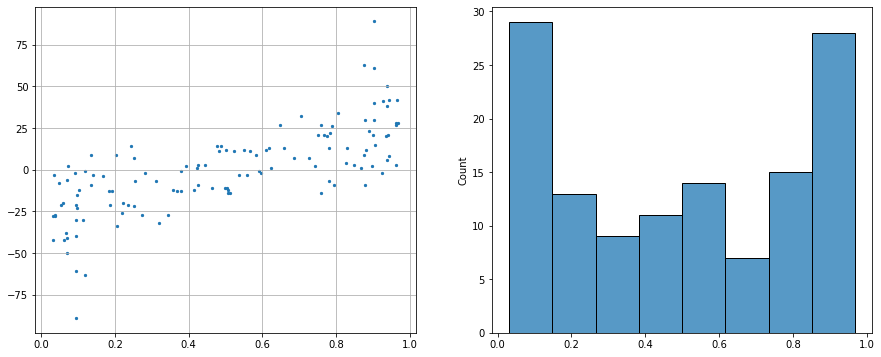

	 -> Scored 0.131

Validating on season 2018


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


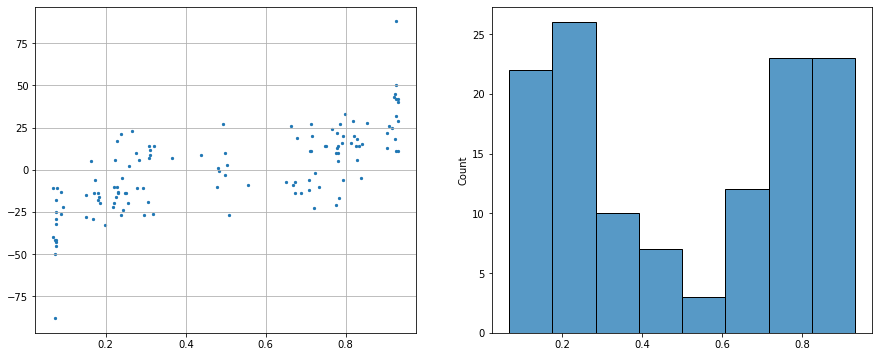

	 -> Scored 0.163

Validating on season 2019


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


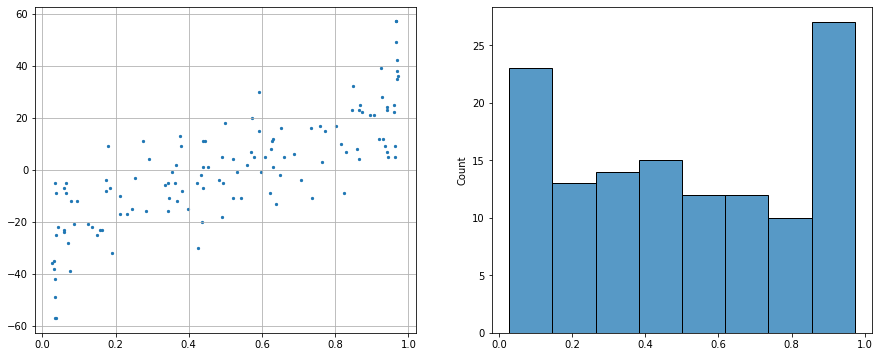

	 -> Scored 0.120

Validating on season 2021


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


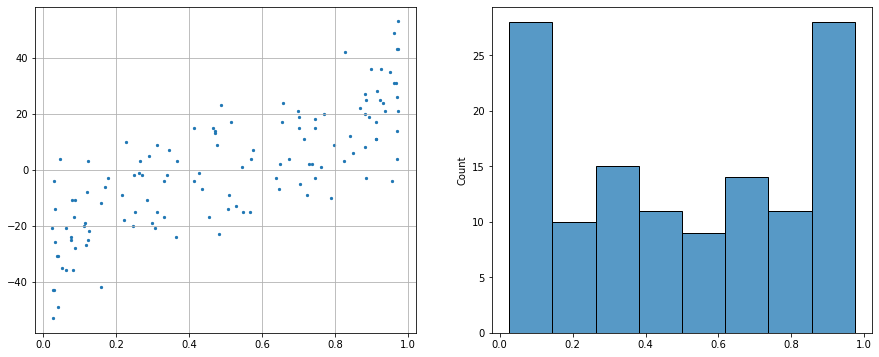

	 -> Scored 0.137

Validating on season 2022


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


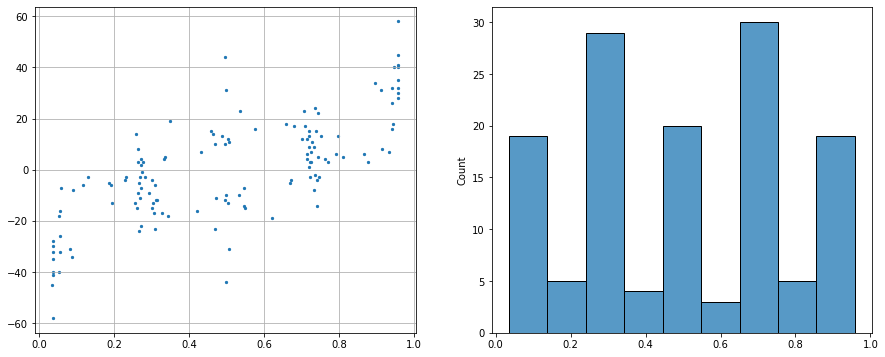

	 -> Scored 0.145

 Local CV is 0.139


In [86]:
pred_tests = kfold(df, df_test, plot=True, verbose=1, xgb = True, tune=False, mode="cls")

In [87]:
pred_test = np.mean(pred_tests, 0)

# _ = sns.displot(pred_test)

# Overriding predictions
- Without overridees, the 4 features model achieved 22nd, which is good but enough !

## Prepare

In [88]:
pred_test.shape

(64980,)

In [89]:
sub = df_test[['ID', 'Season', 'Pred', 'TeamIdA', 'TeamIdB', 'SeedA', 'SeedB', 'WinRatioDiff','538ratingDiff', 'PRIDiff', 'TORateDiff', 'DRAvgDiff']].copy()
sub.to_csv('test_csv', index=False)

In [90]:
sub['Pred'] = pred_test

In [91]:
# sub = sub[sub['538ratingDiff'] != 0]

In [92]:
df_teams = pd.read_csv(DATA_PATH + "WTeams.csv")
sub = sub.merge(df_teams, left_on="TeamIdA", right_on="TeamID").drop('TeamID', axis=1).rename(columns={"TeamName": "TeamA"})
sub = sub.merge(df_teams, left_on="TeamIdB", right_on="TeamID").drop('TeamID', axis=1).rename(columns={"TeamName": "TeamB"})

In [93]:
df_seeds['Seed'] = df_seeds['Seed'].apply(lambda x:x[0])
sub = sub.merge(df_seeds, left_on=["TeamIdA", "Season"], right_on=["TeamID", "Season"]).drop('TeamID', axis=1).rename(columns={"Seed": "RegionA"})
sub = sub.merge(df_seeds, left_on=["TeamIdB", "Season"], right_on=["TeamID", "Season"]).drop('TeamID', axis=1).rename(columns={"Seed": "RegionB"})

# TEST


In [94]:
sub_cv = sub[['ID','Pred']].copy()
sub_cv

,ID,Pred
0,2023_3104_3112,0.325561
1,2023_3104_3124,0.347213
2,2023_3112_3124,0.512305
3,2023_3104_3151,0.927672
4,2023_3112_3151,0.951584
...,...,...
2273,2023_3428_3452,0.847659
2274,2023_3436_3452,0.165602
2275,2023_3437_3452,0.834157
2276,2023_3439_3452,0.925435


# Overrides

## Upsets: (Check OA vs OB, TORateDiff)
1. UNLV vs Michigan
2. Princeton vs NC State
3. Florida vs Georgia Florida vs Duke
4. 


In [95]:
upset_teams = ['UNLV', 'Princeton', 'Florida St']

fake_strong = ['Michigan', 'NC State', 'Duke']  # considered for defeated

# strong_teams_safe = best_teams + ['NC State', 'Louisville']  # win 1st round
# strong_teams_risky = strong_teams_safe + ['Texas A&M', 'Arizona', 'Georgia', 'UCLA']  # win 1st round

In [96]:
def overwrite_pred_risky(sub, eps= 0.1):

    new_sub = []
    
    for i, row in sub.iterrows():
        
        # Strong teams (risky) win their first round
        if row['TeamA'] in upset_teams and row['TeamB'] in fake_strong:
            row['Pred'] = row['Pred'] + eps
        elif row['TeamB'] in upset_teams and row['TeamA'] in fake_strong:
            row['Pred'] = row['Pred'] - eps
            
        row['Pred'] = np.clip(row['Pred'], 0.0001, 0.9999)
        
        new_sub.append(row)
        
    return pd.DataFrame(np.array(new_sub), columns=sub.columns)

In [97]:
def overwrite_pred_extrme(sub, eps=1e-5, err=2e-2):    
    new_sub = []
    
    for i, row in sub.iterrows():
        err_to = 0
        row['Pred'] = np.clip(row['Pred'], 0.0001, 0.9999) # clip for safety
        if row['PRIDiff'] >= 0.1 or row['538ratingDiff'] >= 20:
            row['Pred'] = 1 - eps
        elif row['PRIDiff'] <= -0.1 or row['538ratingDiff'] <= -20:
            row['Pred'] = eps
        else:
            
            if row['Pred'] > 0.12 and row['Pred'] < 0.45:   
                if row['PRIDiff'] < -0.055:
                    err_to += err*1.5
                    if row['TORateDiff'] > 2.2 or row['DRAvgDiff'] < -3.7:
                        err_to += err*0.8
                if row['538ratingDiff'] <= -10.5:
                    err_to += err*1.5
                    if row['TORateDiff'] > 2.2 or row['DRAvgDiff'] < -3.7:
                        err_to += err*0.8
                row['Pred'] = row['Pred'] - err_to
                
            elif row['Pred'] < 0.88 and row['Pred'] > 0.55:
                if row['PRIDiff'] > 0.055:
                    err_to += err*1.5
                    if row['TORateDiff'] < -2.2 or row['DRAvgDiff'] > 3.7:
                        err_to += err*0.8
                if row['538ratingDiff'] >= 10.5:
                    err_to += err*1.5
                    if row['TORateDiff'] < -2.2 or row['DRAvgDiff'] > 3.7:
                        err_to += err*0.8 
                row['Pred'] = row['Pred'] + err_to

        row['Pred'] = np.clip(row['Pred'], 0.0001, 0.9999)
        
        new_sub.append(row)
        
    return pd.DataFrame(np.array(new_sub), columns=sub.columns)

In [98]:
sub_pp = overwrite_pred_extrme(sub)
sub_pp = overwrite_pred_risky(sub_pp)

# sub_pp = sub

## Submission

In [99]:
final_sub = sub_pp[['ID', 'Pred']].copy()
final_sub.to_csv('submission_female.csv', index=False)

<AxesSubplot:>

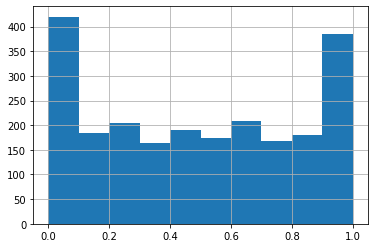

In [100]:
final_sub['Pred'].hist()